### Feed-forward coordinate prediction (DualOutput)

In [1]:
'''
Imports external and own libraries
'''

import pickle

import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable

# own
import collector
import action
import world
import plot
import preprocess
import nets
import train

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [2]:
'''
Load data with pickle (deserialize)
'''
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

with open('datasets/oracle_reversed_random_data.pickle', 'rb') as handle:
    oracle_reversed_random_data = pickle.load(handle)
    
with open('datasets/random_data.pickle', 'rb') as handle:
    random_data = pickle.load(handle)

with open('datasets/tmaze_random_reverse_data.pickle', 'rb') as handle:
    tmaze_random_reverse_data = pickle.load(handle)

In [3]:
pred_coordinates = nets.DualOutput()
summary(pred_coordinates, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 1]              85
            Linear-8                  [-1, 120]          48,120
            Linear-9                   [-1, 84]          10,164
           Linear-10                    [-1, 1]              85
Total params: 119,610
Trainable params: 119,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.46
Estimated T

In [4]:
'''
Use Dataloader to make the data ready for the training loop
'''
train_data, test_data = preprocess.split_data(tmaze_random_reverse_data, 0.8)

# preprocess trainingset 
oracle_train_data = preprocess.ObtainDataset(train_data, 'observations', 'positions')
oracle_test_data = preprocess.ObtainDataset(test_data, 'observations', 'positions')

# build dataloader (tensor format)
batch_size = 64
dataset_loader_train_data = DataLoader(oracle_train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(oracle_test_data, batch_size=batch_size, shuffle=True)

Progress:   0%|          | 0/500 [00:00<?, ? Episode/s]

Epoch: 1, Train Loss: 8.672, Train Acc: 31.34 %,  Test Loss: 4.448, Test Acc: 25.88 %,
Epoch: 11, Train Loss: 4.427, Train Acc: 27.06 %,  Test Loss: 4.551, Test Acc: 25.25 %,
Epoch: 21, Train Loss: 4.406, Train Acc: 28.41 %,  Test Loss: 4.539, Test Acc: 29.62 %,
Epoch: 31, Train Loss: 4.375, Train Acc: 27.12 %,  Test Loss: 4.442, Test Acc: 24.5 %,
Epoch: 41, Train Loss: 4.219, Train Acc: 25.44 %,  Test Loss: 4.428, Test Acc: 23.12 %,
Epoch: 51, Train Loss: 4.003, Train Acc: 26.12 %,  Test Loss: 4.133, Test Acc: 26.12 %,
Epoch: 61, Train Loss: 3.739, Train Acc: 25.56 %,  Test Loss: 3.765, Test Acc: 26.0 %,
Epoch: 71, Train Loss: 3.639, Train Acc: 25.84 %,  Test Loss: 3.966, Test Acc: 26.62 %,
Epoch: 81, Train Loss: 3.507, Train Acc: 28.16 %,  Test Loss: 3.957, Test Acc: 26.12 %,
Epoch: 91, Train Loss: 3.346, Train Acc: 29.75 %,  Test Loss: 3.561, Test Acc: 30.38 %,
Epoch: 101, Train Loss: 3.367, Train Acc: 29.72 %,  Test Loss: 3.775, Test Acc: 27.12 %,
Epoch: 111, Train Loss: 3.249, Tra

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


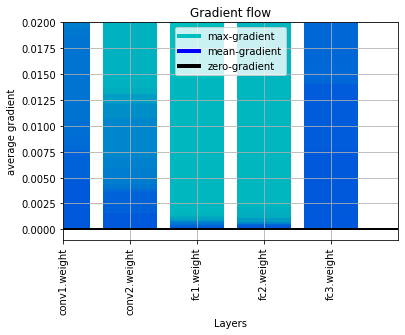

In [5]:
'''
Train the network
- obtained with RMS, lr=0.0005, 200 episodes: train acc. 4% (73 loss), test acc. 4%
- obtained with RMS, lr=0.0005, 300 episodes: train acc. 5% (60 loss), test acc. 6%
- obtained with RMS, lr=0.0005, 400 episodes: train acc. 6% (56 loss), test acc. 6%

- what with a lr. of 0.001?
Learning then stagnates; decrease learning rate?
Change weight initialization?
'''

criterion = nn.MSELoss() # CrossEntropyLoss
optimizer = optim.RMSprop(pred_coordinates.parameters(), lr=0.001) # RMSprop, Adam, SGD

episodes = 500
pred_coordinates, train_loss, test_loss, train_acc, test_acc  = train.DualOutput(dataset_loader_train_data, dataset_loader_test_data, 
                                                                           pred_coordinates, criterion, optimizer, episodes)


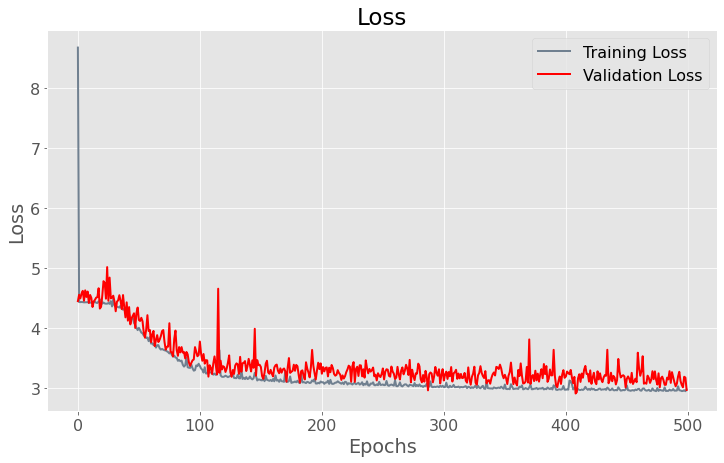

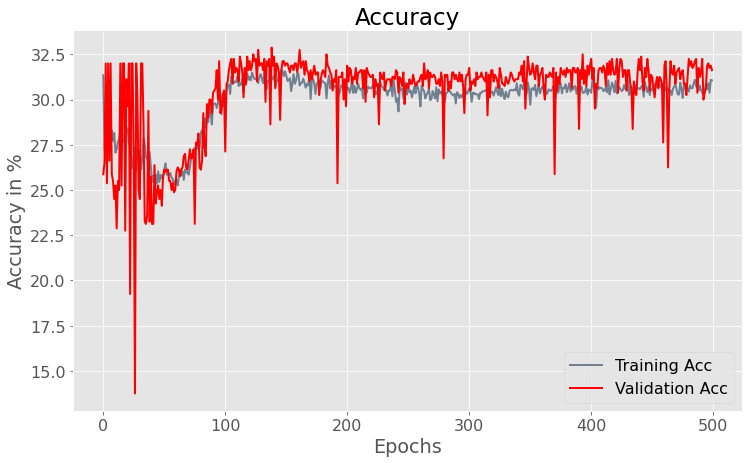

In [6]:
'''
Plot loss and accuracy curves for training and test set
'''

plot.plot_losses(train_loss, test_loss)
plot.plot_acc(train_acc, test_acc, smooth=False)

In [ ]:
'''
Save and load model
'''
import torch 

torch.save(net, 'models/DualOutput2.pt')